# Exploratory Data Analysis 

In [4]:
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic, SVD, CoClustering
from surprise.accuracy import rmse,mae

In [5]:
links_df = pd.read_csv('MovieLens_100k/links.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
tags_df = pd.read_csv('MovieLens_100k/tags.csv')

datasets = {
    "Links": links_df,
    "Movies": movies_df,
    "Ratings": ratings_df,
    "Tags": tags_df
}

datasets_info = {name: df.head() for name, df in datasets.items()}
datasets_info

{'Links':    movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
 'Movies':    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
 'Ratings':    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  9

# Exploratory Data Analysis 

In [6]:
# Check for missing values in each dataset
missing_values = {name: df.isnull().sum() for name, df in datasets.items()}

# Print the information about missing values
for name, missing in missing_values.items():
    print(f"Missing values in {name} dataset:\n{missing}\n")

Missing values in Links dataset:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Tags dataset:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64



In [7]:
# Print the shape of each DataFrame
for name, df in datasets.items():
    print(f"The shape of the {name} DataFrame is: {df.shape}")

The shape of the Links DataFrame is: (9742, 3)
The shape of the Movies DataFrame is: (9742, 3)
The shape of the Ratings DataFrame is: (100836, 4)
The shape of the Tags DataFrame is: (3683, 4)


In [8]:
distribution_of_ratings = ratings_df.groupby('rating').size().reset_index(name='count')
distribution_of_ratings

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


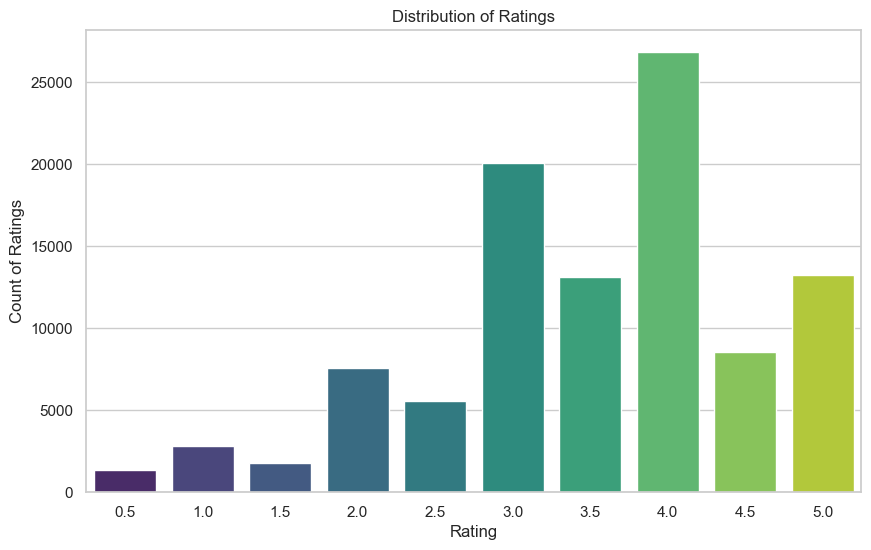

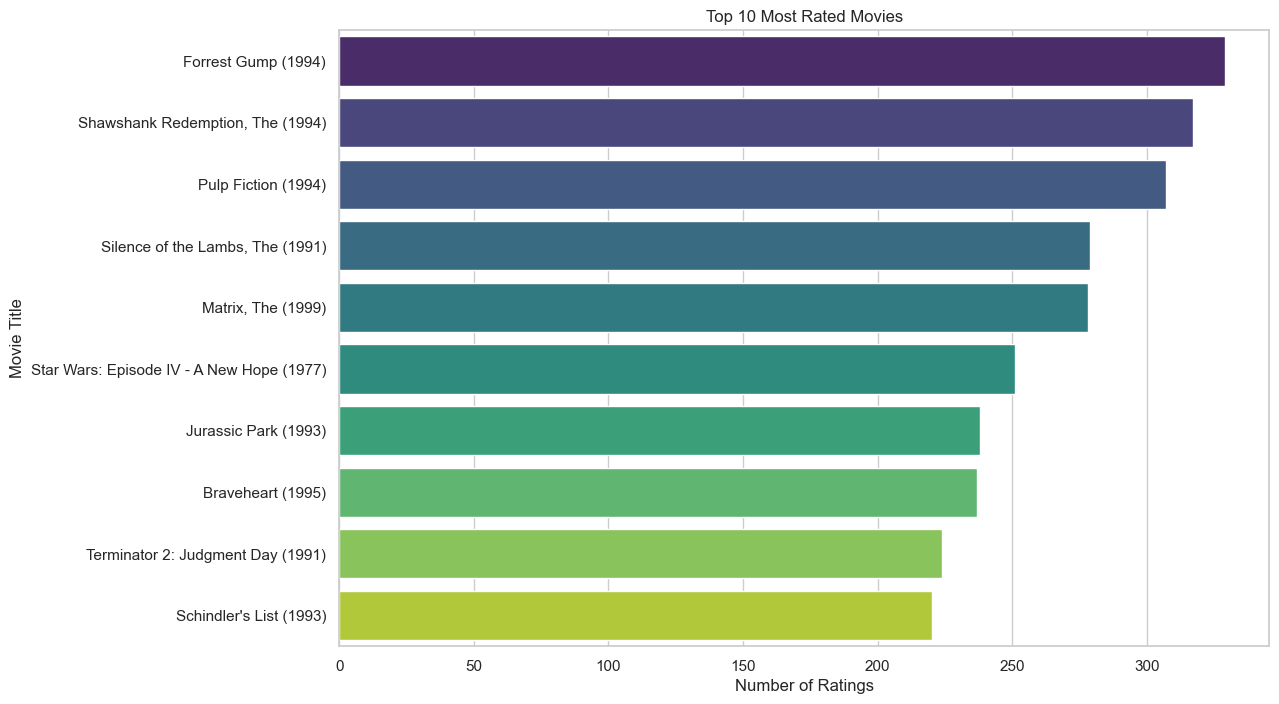

In [9]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count of Ratings')
plt.show()

# Finding the most rated movies by merging ratings with movies for better insight
most_rated_movies = ratings_df.groupby('movieId').size().sort_values(ascending=False).head(10).reset_index(name='count')
most_rated_movies = most_rated_movies.merge(movies_df, on='movieId', how='left')

# Plotting the most rated movies
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='title', data=most_rated_movies, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

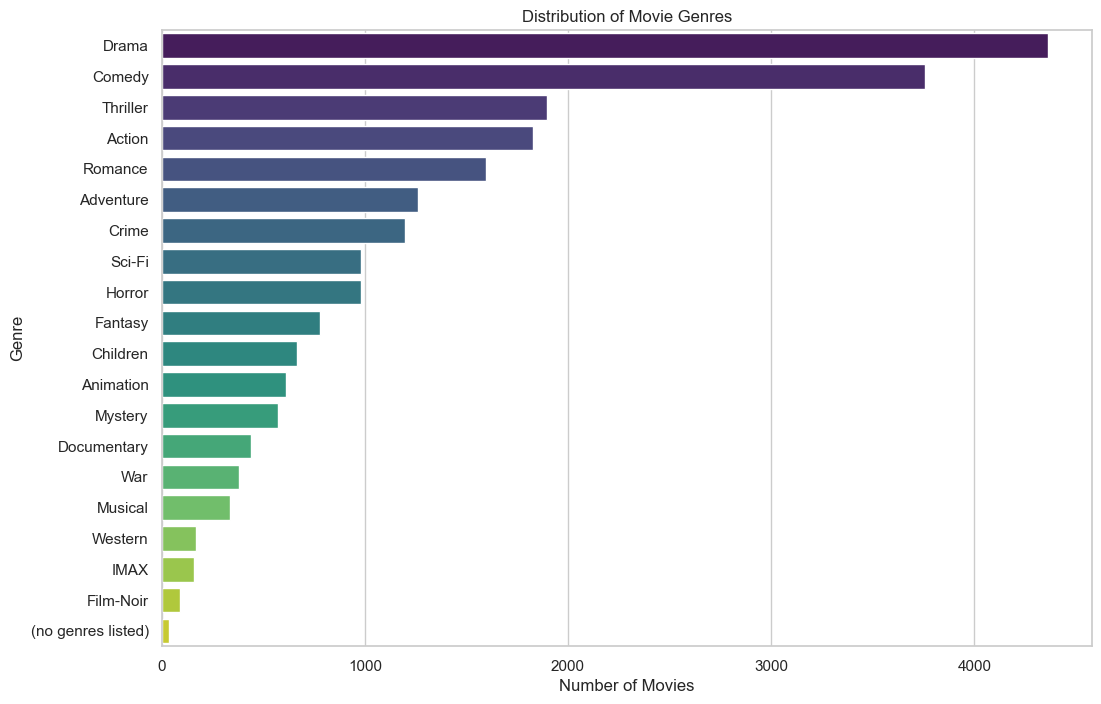

In [10]:
# Split the genres for each movie and count the occurrences of each genre
genre_counts = Counter(g for genres in movies_df['genres'] for g in genres.split('|'))

# Create a dataframe for the genre counts
genres_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plotting the genre distribution
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre', data=genres_df, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# Average rating EDA

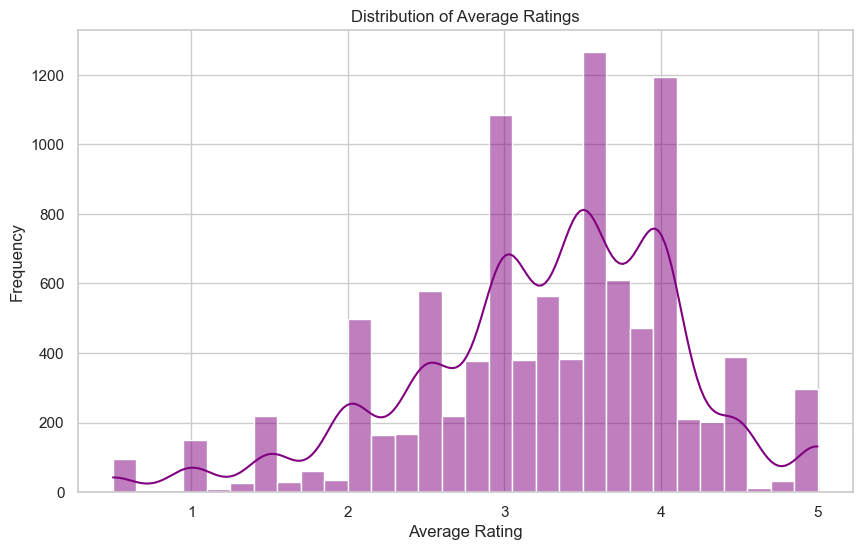

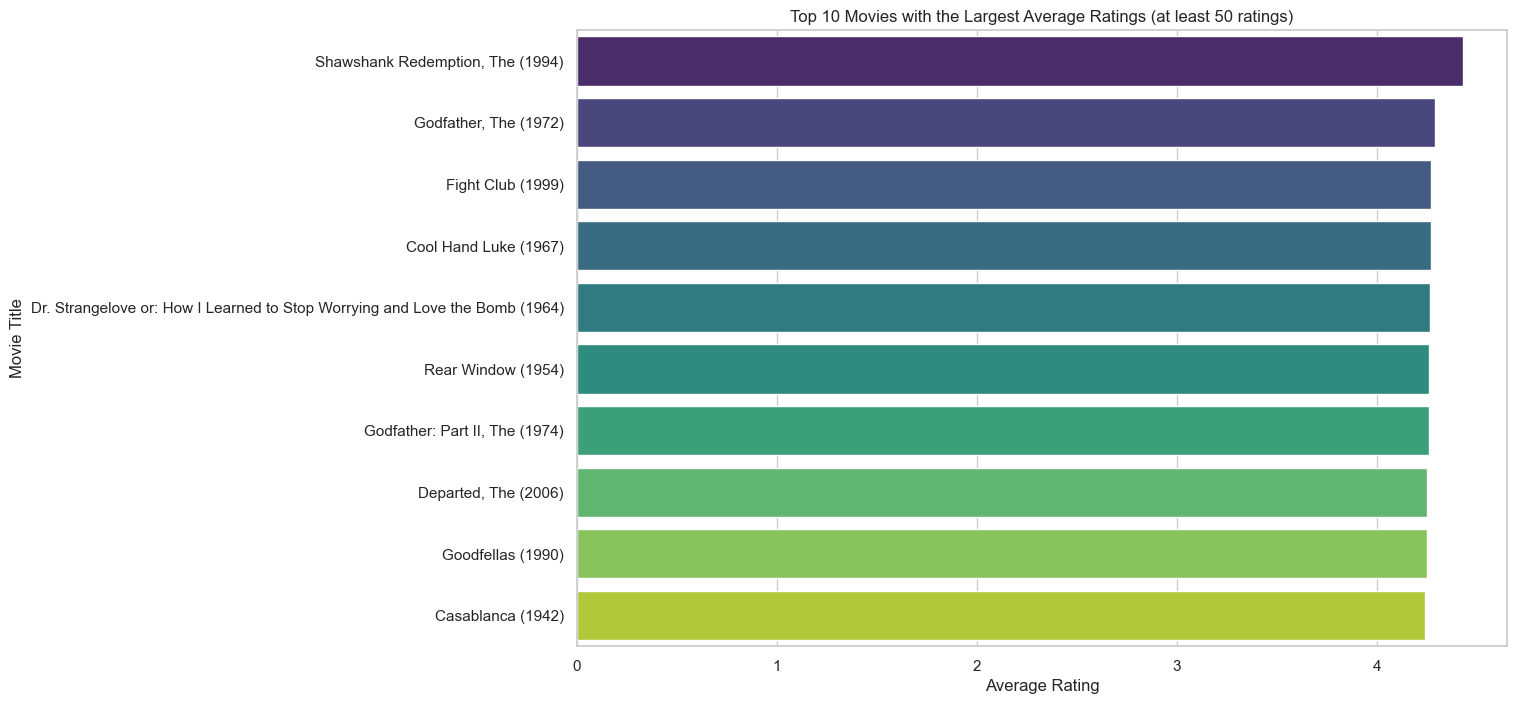

In [11]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Calculate average ratings
average_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()
average_ratings.columns = ['movieId', 'average_rating']

# Merge with movies data
average_ratings = average_ratings.merge(movies_df, on='movieId', how='left')

# Distribution of Average Ratings
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings['average_rating'], bins=30, kde=True, color='purple')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Filter movies with at least 100 ratings
movies_with_100_ratings = ratings_df.groupby('movieId').filter(lambda x: len(x) >= 50)

# Calculate average ratings for these movies
average_ratings_100 = movies_with_100_ratings.groupby('movieId')['rating'].mean().reset_index()
average_ratings_100.columns = ['movieId', 'average_rating']

# Merge with movies data
average_ratings_100 = average_ratings_100.merge(movies_df, on='movieId', how='left')

average_ratings_100.replace([np.inf, -np.inf], np.nan, inplace=True)
average_ratings_100.dropna(subset=['average_rating'], how='any', inplace=True)


# Top 10 Movies with the Largest Average Ratings
top_10_avg_ratings_100 = average_ratings_100.sort_values(by='average_rating', ascending=False).head(10)

# Plotting Top 10 Movies with the Largest Average Ratings
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='title', data=top_10_avg_ratings_100, palette='viridis')
plt.title('Top 10 Movies with the Largest Average Ratings (at least 50 ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

# Calculate number of ratings per user
ratings_per_user = ratings_df.groupby('userId').size().reset_index(name='count')

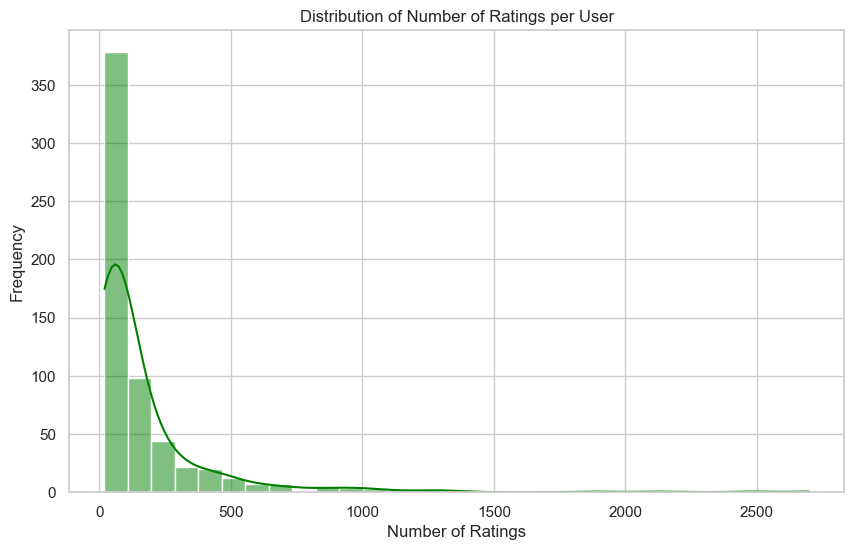

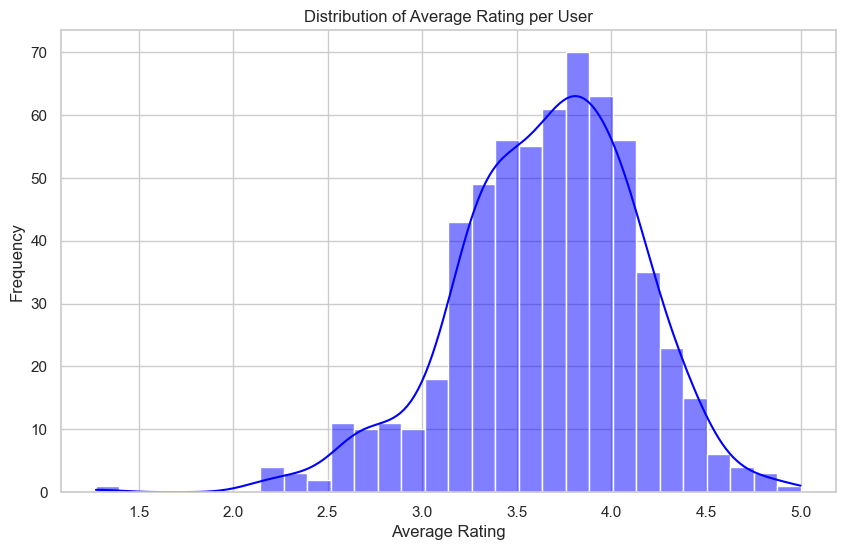

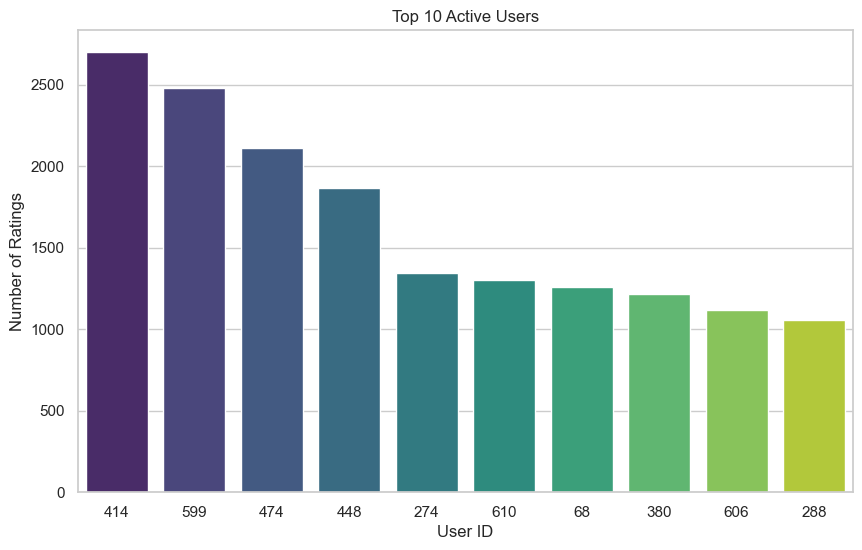

In [12]:
# Distribution of Number of Ratings per User
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user['count'], bins=30, kde=True, color='green')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Calculate average rating per user
average_rating_per_user = ratings_df.groupby('userId')['rating'].mean().reset_index()
average_rating_per_user.columns = ['userId', 'average_rating']

# Distribution of Average Rating per User
plt.figure(figsize=(10, 6))
sns.histplot(average_rating_per_user['average_rating'], bins=30, kde=True, color='blue')
plt.title('Distribution of Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Top 10 Active Users
top_10_active_users = ratings_per_user.sort_values(by='count', ascending=False).head(10)

# sort IDs by activity level
top_10_active_users = top_10_active_users.sort_values(by='count', ascending=False)

# Plotting Top 10 Active Users
plt.figure(figsize=(10, 6))
sns.barplot(x='userId', y='count', data=top_10_active_users, palette='viridis', order=top_10_active_users['userId'])
plt.title('Top 10 Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()

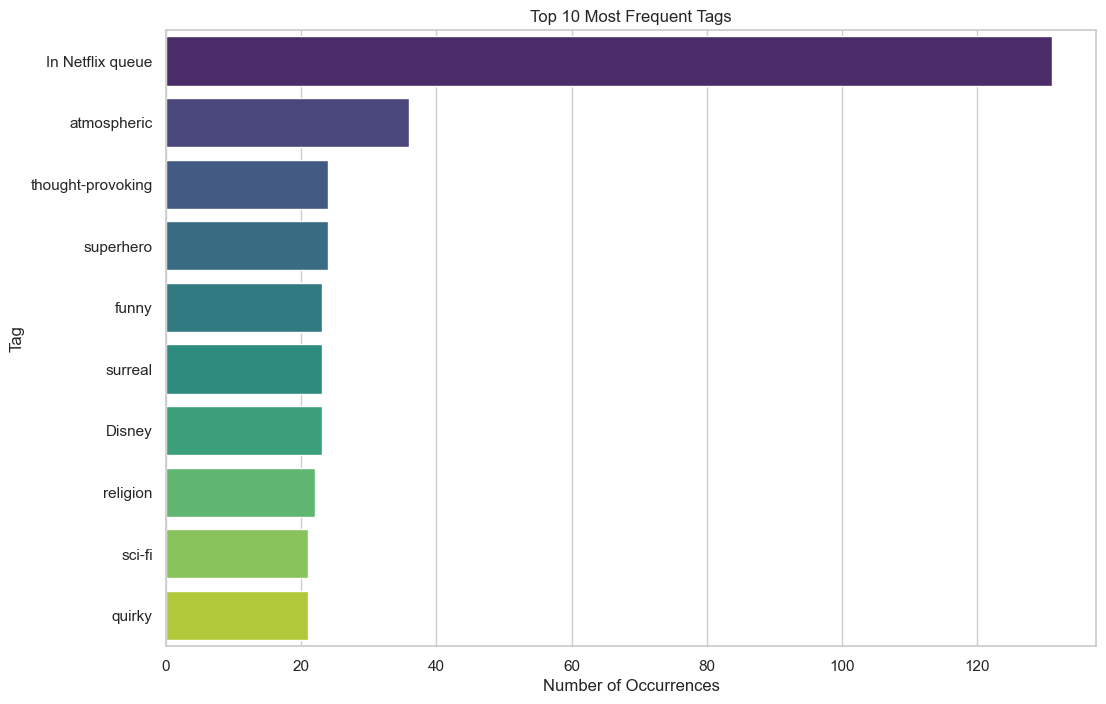

In [13]:
# Count the occurrences of each tag
tag_counts = tags_df['tag'].value_counts().head(10)

# Create a dataframe for the tag counts
tags_count_df = pd.DataFrame({'Tag': tag_counts.index, 'Count': tag_counts.values})

# Plotting the most common tags
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Tag', data=tags_count_df, palette='viridis')
plt.title('Top 10 Most Frequent Tags')
plt.xlabel('Number of Occurrences')
plt.ylabel('Tag')
plt.show()

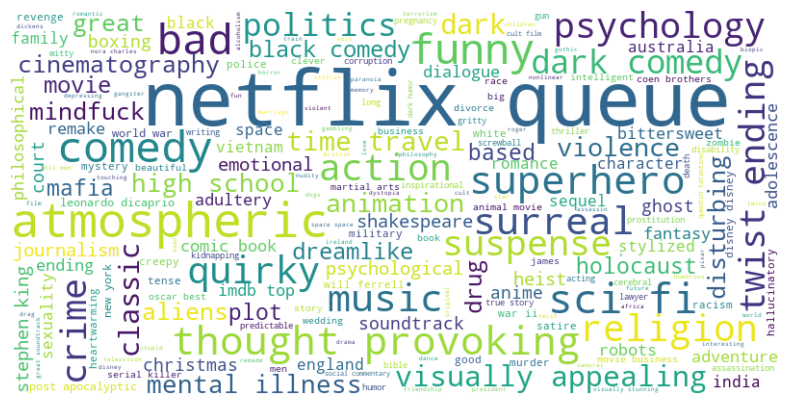

In [14]:
tags_list = tags_df['tag'].tolist()

# Convert list to a single string for word cloud generation
all_tags = ' '.join(tags_list).lower()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

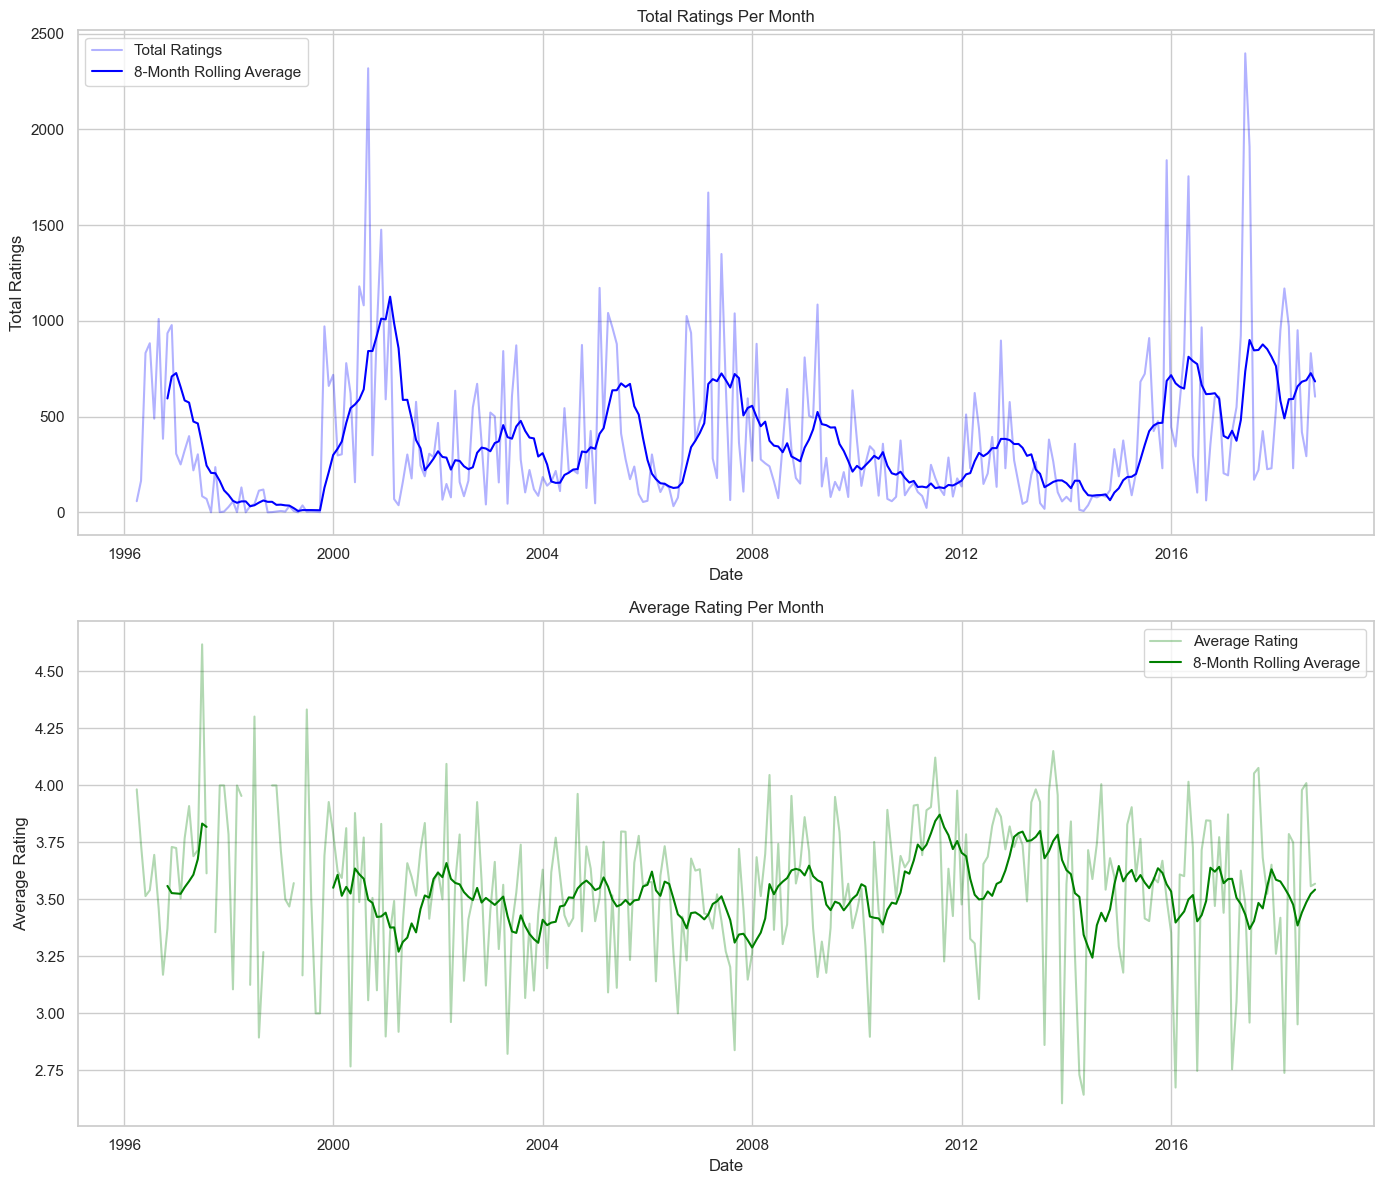

In [15]:
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Aggregate total number of ratings and average ratings per month
ratings_per_month = ratings_df.groupby(pd.Grouper(key='datetime', freq='M')).agg({
    'rating': ['count', 'mean']
}).rename(columns={'count': 'Total Rating', 'mean': 'Average Rating'})

# Flatten the MultiIndex columns
ratings_per_month.columns = ['Total Rating', 'Average Rating']

# Calculate the rolling average with a 8-month window
ratings_per_month['Total Rating Rolling'] = ratings_per_month['Total Rating'].rolling(window=8).mean()
ratings_per_month['Average Rating Rolling'] = ratings_per_month['Average Rating'].rolling(window=8).mean()

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Monthly ratings
ax[0].plot(ratings_per_month.index, ratings_per_month['Total Rating'], label='Total Ratings', color='blue', alpha=0.3)
ax[0].plot(ratings_per_month.index, ratings_per_month['Total Rating Rolling'], label='8-Month Rolling Average', color='blue')
ax[0].set_title('Total Ratings Per Month')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Ratings')
ax[0].legend()

# Average ratings
ax[1].plot(ratings_per_month.index, ratings_per_month['Average Rating'], label='Average Rating', color='green', alpha=0.3)
ax[1].plot(ratings_per_month.index, ratings_per_month['Average Rating Rolling'], label='8-Month Rolling Average', color='green')
ax[1].set_title('Average Rating Per Month')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Average Rating')
ax[1].legend()

plt.tight_layout()
plt.show()
